In [ ]:
import tensorflow as tf
print(tf.__version__)

2024-06-09 17:18:35.917704: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 17:18:36.163353: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-09 17:18:39.040013: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.16.1


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf

In [3]:
import librosa
# Utility functions for loading audio files and making sure the sample rate is correct.
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    y, sr = librosa.load(filename, sr=16000, mono=True) # y = audio time series
    return y

In [ ]:
# Utility functions for loading audio files and making sure the sample rate is correct.
def extract_mel_diagram(audio_signal):
    # Parameters as utilized in the VGGish and YAMnet models
    sr = 16000 # sampling rate used by VGGish and YAMnet
    n_fft = int(0.025 * sr)  # 25 ms
    hop_length = int(0.010 * sr)  # 10 ms
    n_mels = 64  # Mel bins
    fmax = 8000  # Max 8 kHz frequency

    # Calculate spectogram
    S = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)
    return S

In [5]:
files_csv = './dataset_metadata.csv'

pd_data = pd.read_csv(files_csv)
pd_data.head()

,filename,emotion,target
0,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
1,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
2,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
3,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0
4,/run/media/rodrigo/Data SSD (2TB)/Unifei/Compu...,neutral,0


In [ ]:
my_classes = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgusted', 'surprised']
#my_classes = ['Neutra', 'Calma', 'Felicidade', 'Tristeza', 'Raiva', 'Medo', 'Surpresa', 'Nojo']

In [17]:
filenames = pd_data['filename']
targets = pd_data['target']
emotions = pd_data['emotion']
dataset = []

for f in filenames:
    wav = np.array(load_wav_16k_mono(f))
    dataset.append(wav)

In [18]:
highest_audio_length = len(max(dataset, key=len))

# Padding audios shorter than the highest audio length with 0's to normalize and allow passing through models
for index, audio_file in enumerate(dataset):
    if len(audio_file) < highest_audio_length:
        dataset[index] = librosa.util.pad_center(audio_file, size=highest_audio_length, mode='constant')

In [ ]:
# The embedding extraction returns a 1024-D tensor for each 0,96 sec of audio. Need to flatten the embeddings to pass through classifiers
# The embeddings tensor will be a Tensor with N positions (1 position for each 0,96 sec), where each position is the 1024-D tensor
# Generating an embedding to get its shape, and latter flatten (reshape) the tensors with the correct dimmensions
temp_mel_diagram = extract_mel_diagram(dataset[0])
embeddings_shape = temp_mel_diagram.shape
number_of_tensors = embeddings_shape[0]
embeddings_length = embeddings_shape[1]
flattened_dimmension = number_of_tensors * embeddings_length

# Extract embeddings
for index, wav_file in enumerate(dataset):
    mel_diagram = extract_mel_diagram(wav_file)
    flattened_tensor = tf.reshape(mel_diagram, [flattened_dimmension])
    numpy_array = flattened_tensor.numpy()
    dataset[index] = numpy_array

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict

kf = KFold(n_splits=5, shuffle=True, random_state=42)
X = dataset.copy()
Y = targets.copy()
crossvalidation_scores =[]

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm

pipe = Pipeline(steps=[('scaler', StandardScaler()), ('svm', svm.SVC())])

In [22]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
scores = cross_val_score(pipe, X, Y, cv=kf)

y_pred = cross_val_predict(pipe, X, Y, cv=kf)

Fold 1: Score = 0.2257
Fold 2: Score = 0.2188
Fold 3: Score = 0.1736
Fold 4: Score = 0.2361
Fold 5: Score = 0.2222
Average Score: 0.2153 +- 0.0216
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.17      0.74      0.27       192
           2       0.30      0.06      0.10       192
           3       0.13      0.16      0.14       192
           4       0.44      0.50      0.47       192
           5       0.50      0.05      0.09       192
           6       0.17      0.01      0.01       192
           7       0.31      0.10      0.15       192

    accuracy                           0.22      1440
   macro avg       0.25      0.20      0.15      1440
weighted avg       0.27      0.22      0.16      1440



/run/media/rodrigo/Data SSD (2TB)/Unifei/Computaçao/TCC/Teste jupyter/notebooks/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/run/media/rodrigo/Data SSD (2TB)/Unifei/Computaçao/TCC/Teste jupyter/notebooks/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/run/media/rodrigo/Data SSD (2TB)/Unifei/Computaçao/TCC/Teste jupyter/notebooks/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in label

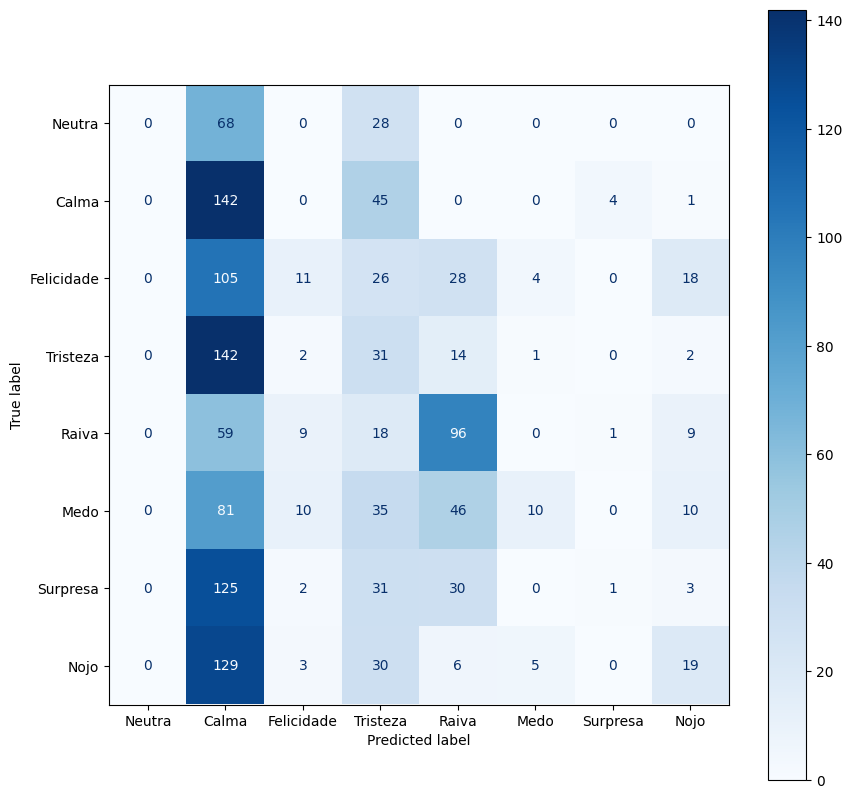

In [23]:
for fold_index, score in enumerate(scores):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores):.4f} +- {np.std(scores):.4f}")

print(metrics.classification_report(Y, y_pred))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred, cmap='Blues', display_labels=my_classes, ax=ax)

Fold 1: Score = 0.5174
Fold 2: Score = 0.4688
Fold 3: Score = 0.5278
Fold 4: Score = 0.4826
Fold 5: Score = 0.5347
Average Score: 0.5062 +- 0.0259
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        96
           1       0.58      0.74      0.65       192
           2       0.37      0.28      0.32       192
           3       0.41      0.37      0.39       192
           4       0.62      0.57      0.60       192
           5       0.58      0.46      0.51       192
           6       0.57      0.68      0.62       192
           7       0.47      0.60      0.53       192

    accuracy                           0.52      1440
   macro avg       0.51      0.51      0.51      1440
weighted avg       0.51      0.52      0.51      1440



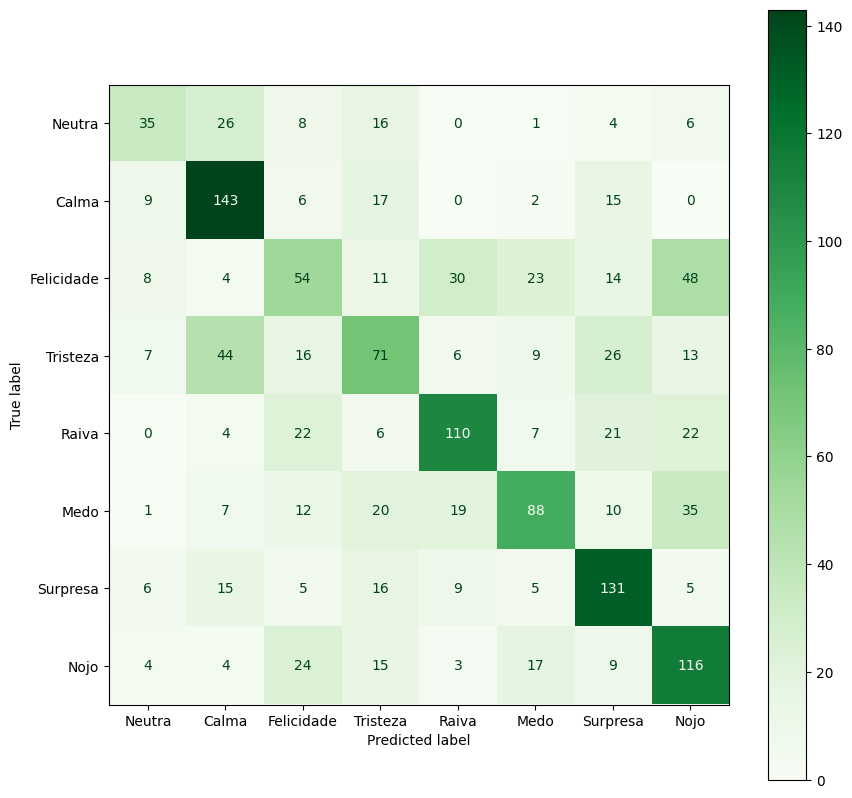

In [24]:
#SCIKIT Random Forest
from sklearn.ensemble import RandomForestClassifier

pipe_forest = Pipeline(steps=[('scaler', StandardScaler()), ('forest', RandomForestClassifier())])

scores_forest = cross_val_score(pipe_forest, X, Y, cv=kf)

y_pred_forest = cross_val_predict(pipe_forest, X, Y, cv=kf)

for fold_index, score in enumerate(scores_forest):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores_forest):.4f} +- {np.std(scores_forest):.4f}")

print(metrics.classification_report(Y, y_pred_forest))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred_forest, cmap='Greens', display_labels=my_classes, ax=ax)

Fold 1: Score = 0.3229
Fold 2: Score = 0.2535
Fold 3: Score = 0.3368
Fold 4: Score = 0.3090
Fold 5: Score = 0.2986
Average Score: 0.3042 +- 0.0284
              precision    recall  f1-score   support

           0       0.23      0.67      0.34        96
           1       0.62      0.23      0.34       192
           2       0.22      0.26      0.24       192
           3       0.21      0.11      0.14       192
           4       0.44      0.51      0.47       192
           5       0.31      0.15      0.20       192
           6       0.37      0.10      0.16       192
           7       0.29      0.58      0.38       192

    accuracy                           0.30      1440
   macro avg       0.34      0.33      0.29      1440
weighted avg       0.34      0.30      0.28      1440



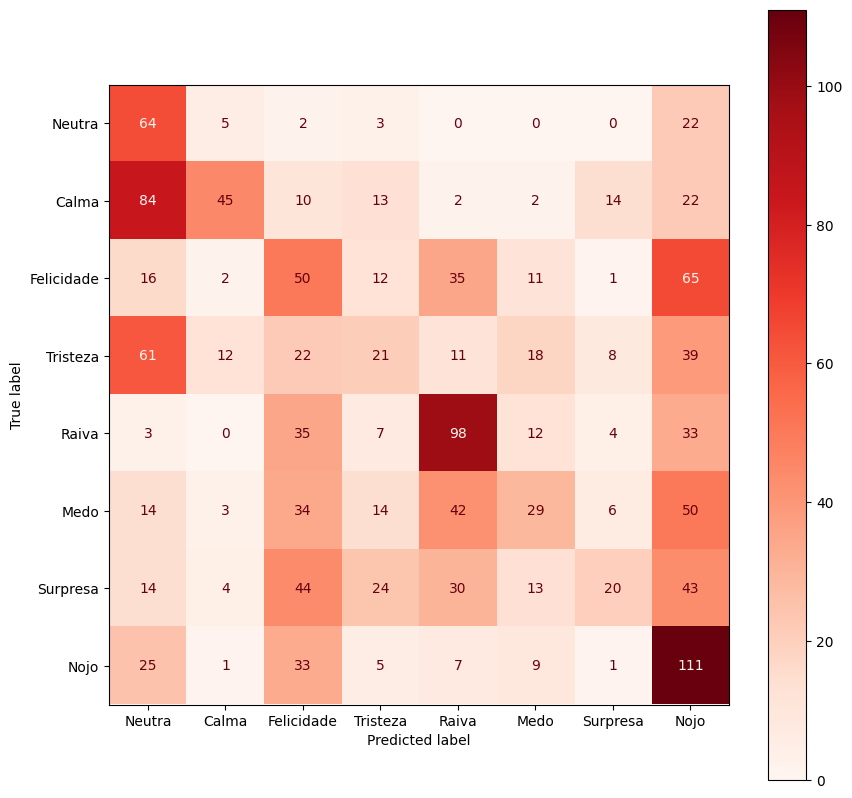

In [25]:
# SVM Naive Bayes
from sklearn.naive_bayes import GaussianNB

pipe_naive_bayes = Pipeline(steps=[('scaler', StandardScaler()), ('naive', GaussianNB() )])

scores_naive_bayes = cross_val_score(pipe_naive_bayes, X, Y, cv=kf)

y_pred_naive_bayes = cross_val_predict(GaussianNB(), X, Y, cv=kf)
y_pred_naive_bayes = cross_val_predict(pipe_naive_bayes, X, Y, cv=kf)

for fold_index, score in enumerate(scores_naive_bayes):
    print(f"Fold {fold_index + 1}: Score = {score:.4f}")
print(f"Average Score: {np.mean(scores_naive_bayes):.4f} +- {np.std(scores_naive_bayes):.4f}")

print(metrics.classification_report(Y, y_pred_naive_bayes))

_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(Y, y_pred_naive_bayes, cmap='Reds', display_labels=my_classes, ax=ax)

In [ ]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(flattened_dimmension,), dtype=tf.float32,
                          name='input_embedding_layer'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
], name='my_model')

my_model.summary()

my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=5,
                                            restore_best_weights=True)

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │     4,325,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,334,280 (16.53 MB)

 Trainable params: 4,334,280 (16.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
dataset_numpy = np.array(dataset)
targets_numpy = np.array(targets)

y_true = np.array([], np.int32)
y_pred = np.array([], np.int32)

fold_index = 1
scores_neural_network = np.array([])

for train_indexes, test_indexes in kf.split(dataset_numpy, targets_numpy):
    train_ds = np.array(dataset_numpy[train_indexes])
    train_labels = np.array(targets_numpy[train_indexes])
    
    test_ds = np.array(dataset_numpy[test_indexes])
    test_labels = np.array(targets_numpy[test_indexes])
    
    history = my_model.fit(x=train_ds, y=train_labels,
                       epochs=150,
                       #validation_data=validation_ds,
                       #validation_split=0.25,
                       callbacks=callback,
                       verbose=0)

    loss, accuracy = my_model.evaluate(test_ds, test_labels, verbose=0)
   
    print(f"Fold {fold_index }: Score = {accuracy:.4f}")  
    
    # Adding true labels and predicted labels to their respective arrays
    y_true = np.concatenate((y_true, test_labels))
    
    fold_predictions = my_model.predict(test_ds, verbose=0).argmax(axis=1)
    y_pred = np.concatenate((y_pred, fold_predictions))

    # Adding accuracy to array
    scores_neural_network = np.append(scores_neural_network, [accuracy])

    fold_index += 1
    print()

print(f"\n\nAverage Score: {np.mean(scores_neural_network):.4f} +- {np.std(scores_neural_network):.4f}")
print(metrics.classification_report(y_true, y_pred))

Fold 1: Score = 0.4340

Fold 2: Score = 0.8646

Fold 3: Score = 0.9271

Fold 4: Score = 0.9653

Fold 5: Score = 0.9861



Average Score: 0.8354 +- 0.2049
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        96
           1       0.85      0.96      0.90       192
           2       0.82      0.68      0.74       192
           3       0.80      0.80      0.80       192
           4       0.83      0.86      0.85       192
           5       0.88      0.80      0.84       192
           6       0.89      0.86      0.87       192
           7       0.82      0.88      0.85       192

    accuracy                           0.84      1440
   macro avg       0.83      0.84      0.83      1440
weighted avg       0.84      0.84      0.83      1440



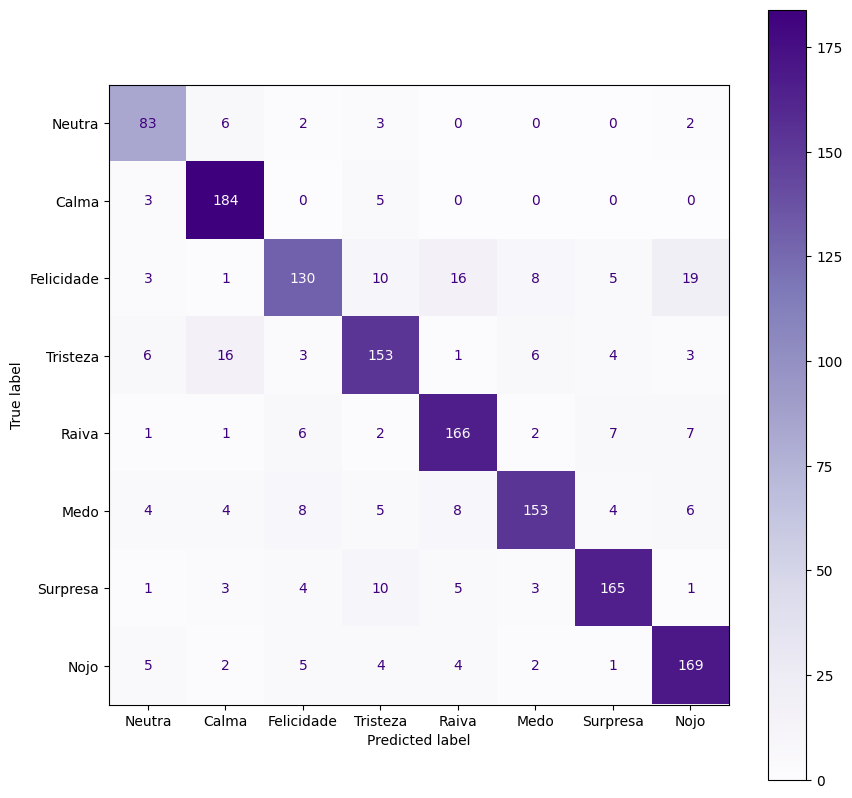

In [38]:
_, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='Purples', display_labels=my_classes, ax=ax)